In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [2]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3896864084219050437
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5996529869
locality {
  bus_id: 1
}
incarnation: 8864180586140644824
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:02:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 5996171879
locality {
  bus_id: 1
}
incarnation: 6228426530845789920
physical_device_desc: "device: 1, name: GeForce GTX 980 Ti, pci bus id: 0000:03:00.0"
]


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.65KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

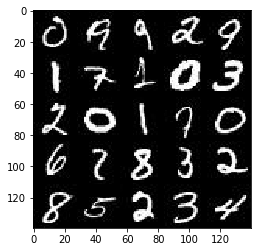

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

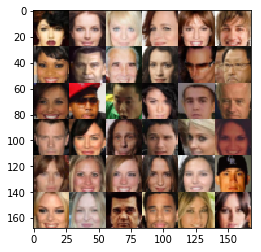

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_ = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "inputs")
    z = tf.placeholder(tf.float32, [None, z_dim], name="z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # input images 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*x1, x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4*4*256
        
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha*bn4, bn4)
        # 2*2*512
        
        # flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train):
        # Input z
        x1 = tf.layers.dense(z, 4*4*512)
        # 4*4*512
        
        x1 = tf.reshape(x1, (-1,4,4,512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(bn1, alpha*bn1)
        # 4*4*512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(bn2, alpha*bn2)
        # 8*8*256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(bn3, alpha*bn3)
        # 16*16*128
        
        x4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(bn4, alpha*bn4)
        # 32*32*32
        
        x5 = tf.layers.conv2d(relu4, out_channel_dim, 5, strides=1, padding="same")
        logits = tf.image.resize_images(x5, [28,28])
        out = tf.tanh(logits)
        # 28*28*3
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator and discriminator
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                    labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                    labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    # generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [i for i in t_vars if "generator" in i.name]
    d_vars = [i for i in t_vars if "discriminator" in i.name]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
losses = []
samples = []
tf_cfg = tf.ConfigProto(allow_soft_placement=True)
tf_cfg.gpu_options.per_process_gpu_memory_fraction = 0.4
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # inputs
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    # loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # generator
    z_generated = generator(input_z, image_channels, is_train=False)
    
    
    iteration = 0
    with tf.Session(config=tf_cfg) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                iteration += 1
                # sample z
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                # show
                if iteration % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if iteration % 10 == 0:
                # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
#                     # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))

#             # Sample from generator as we're training for viewing afterwards
#             sample_z = np.random.uniform(-0.5, 0.5, size=(16, z_dim))
#             gen_samples = sess.run(
#                            z_generated,
#                            feed_dict={input_z: sample_z})
#             samples.append(gen_samples)        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2149... Generator Loss: 3.4726
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.3883
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 7.4149
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 1.8251
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 2.4858
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.2895
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.7803


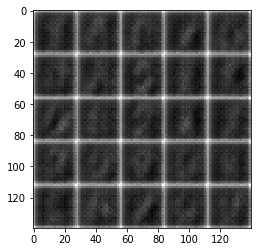

Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 1.2917
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.4546
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 2.2344


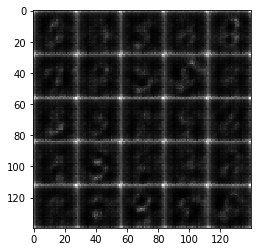

Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.9684
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.8415
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 1.6977
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 2.3902
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 1.7543
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 1.2793
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.2072


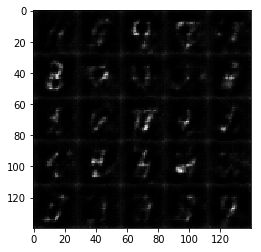

Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 2.1139
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.6323
Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 0.8498... Generator Loss: 2.4002
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 1.3095
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 0.4766... Generator Loss: 1.7407
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.0816


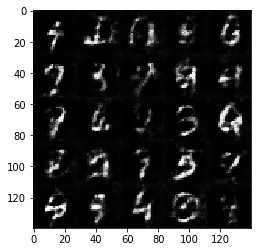

Epoch 1/2... Discriminator Loss: 0.6218... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 0.6583... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 2.3251
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 2.0771
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 2.2521
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 0.7076


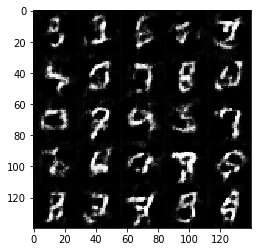

Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 2.1869
Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 1.6879
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 1.5995
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.9693
Epoch 1/2... Discriminator Loss: 0.6541... Generator Loss: 1.3588
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 2.6740
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 0.9281


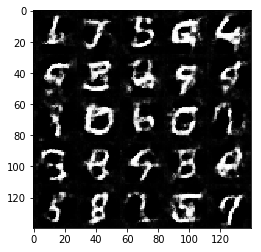

Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 2.1296
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.1177
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.1109
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 1.7255
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 1.3621
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 1.4449


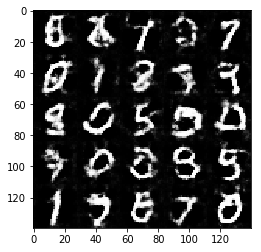

Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.3580
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.6599
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 2.1248
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.9055
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.4138
Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 1.3957


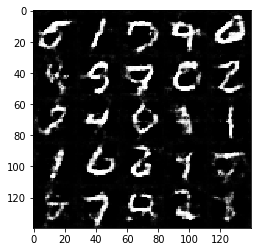

Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 0.7552... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.6180
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 0.8346


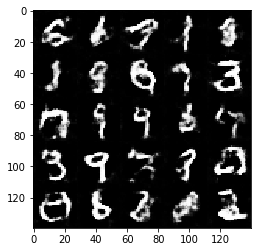

Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 1.7939
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 1.8131
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 0.6995... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 0.5574
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.0313


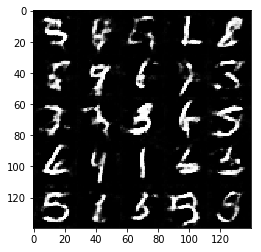

Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 0.5948... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 1.6880
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 0.9976


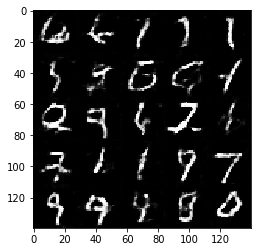

Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 1.3870
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 0.5938... Generator Loss: 1.2496
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.7905
Epoch 2/2... Discriminator Loss: 1.4798... Generator Loss: 0.3617
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 0.5482


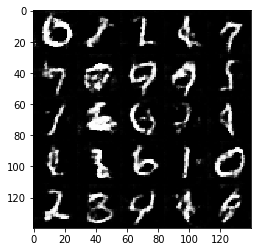

Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 2.7012... Generator Loss: 0.0997
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.1718
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 0.9543


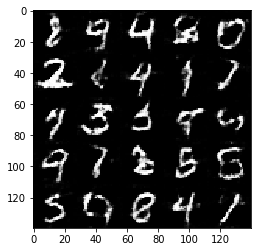

Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 0.9423
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 2.1559
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.5138
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.5818
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 1.8122... Generator Loss: 0.2398
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.4805


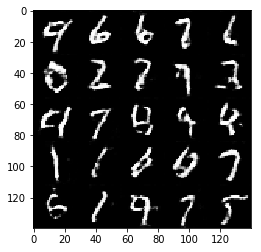

Epoch 2/2... Discriminator Loss: 1.7642... Generator Loss: 0.2308
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 1.6011
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.4777
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 1.1389


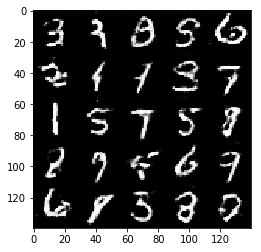

Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 0.8431
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.7230
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 0.5449... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.5763
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 2.6220


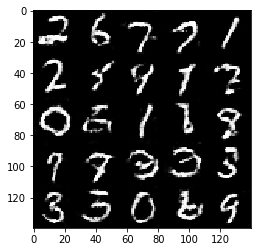

Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.5591... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 1.3127
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.4276
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.6090


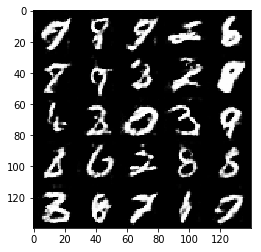

Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.6829... Generator Loss: 0.2360
Epoch 2/2... Discriminator Loss: 0.8343... Generator Loss: 1.5821
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.2858
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 1.3124
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 0.8359


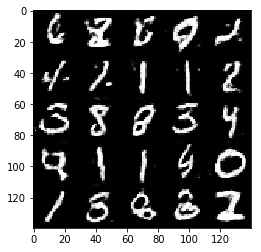

Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.2795
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 3.4986
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.5461


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 0.0896... Generator Loss: 2.8630
Epoch 1/2... Discriminator Loss: 0.1338... Generator Loss: 2.7751
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 3.6328
Epoch 1/2... Discriminator Loss: 0.1400... Generator Loss: 4.0137
Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 1.3411
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 1.7480


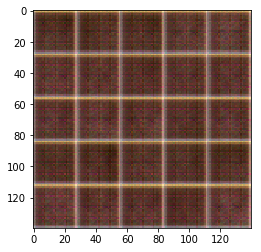

Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 3.4723
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 4.2652
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 1.3463
Epoch 1/2... Discriminator Loss: 0.6344... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 4.1674
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 1.5127


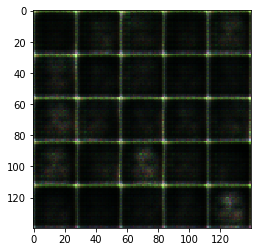

Epoch 1/2... Discriminator Loss: 0.6790... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.3736
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 1.4582
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.5058


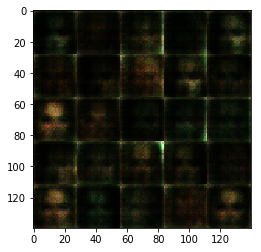

Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.0277
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 1.6986... Generator Loss: 0.3335
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 2.0379
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.9738


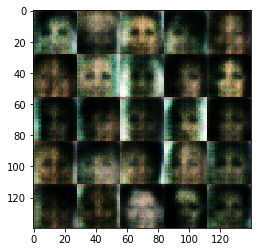

Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 2.0281
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.7067
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.0755
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.3228
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.4350


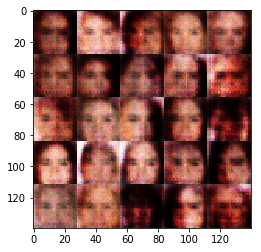

Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 1.3560
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 0.8303


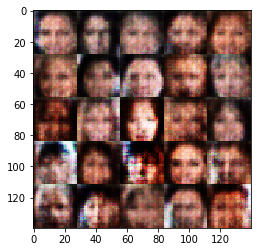

Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.3401
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.6943
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.9207
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.1269


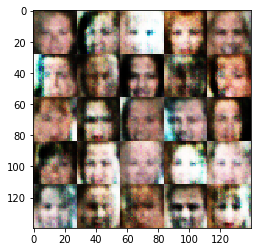

Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.3306
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 1.1698


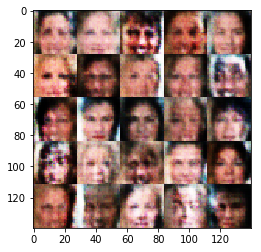

Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.0380
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.7457
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.2426


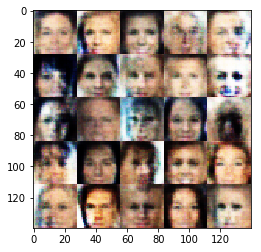

Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.3644
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.1792
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.8211
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.9790


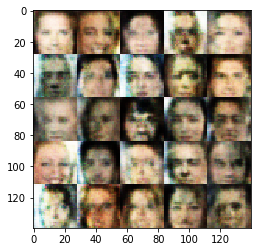

Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.2738
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.4545
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 1.1724
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.4274
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.6655


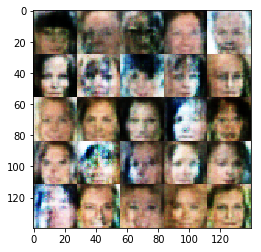

Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 0.8426


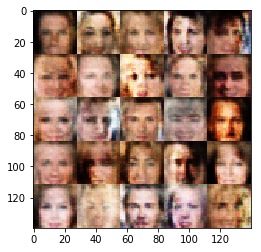

Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 0.7679... Generator Loss: 1.1445


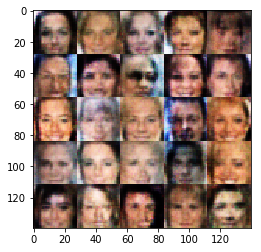

Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 1.4209
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 1.1124
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.5593


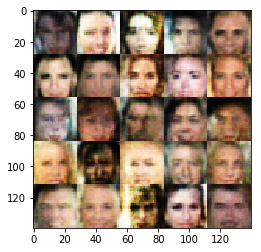

Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.4471
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.2074
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 0.8742


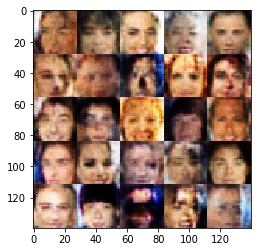

Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.7075


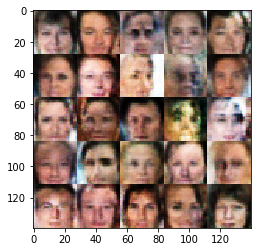

Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.1608
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 1.5477
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 1.1928


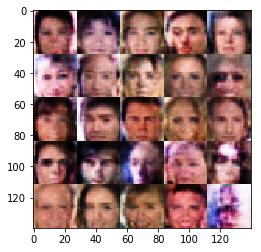

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.3232
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.1462
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.6751


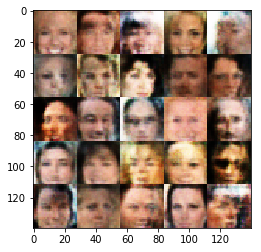

Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 1.3738
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.1376


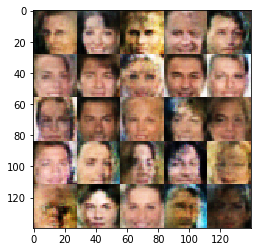

Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 0.8940


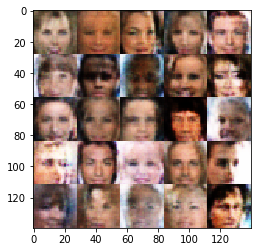

Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 2.3719
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.3040
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.0202... Generator Loss: 0.7410


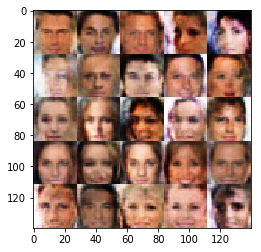

Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 0.4743... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.0880
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.4887


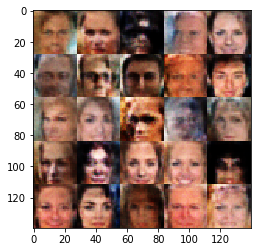

Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 1.6853
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.4310
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 0.8747... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 0.8813... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 1.6853


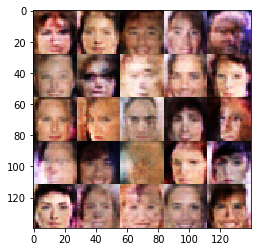

Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 1.0004
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.5553


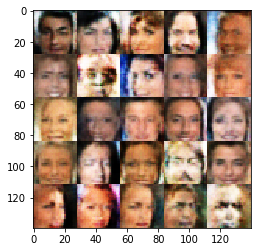

Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.0637
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 0.8684


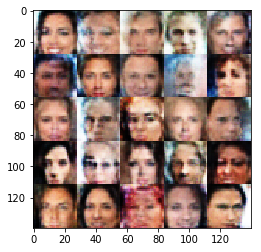

Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.4206
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.5114
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 0.7818


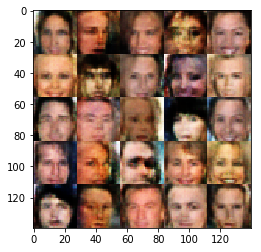

Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.4060


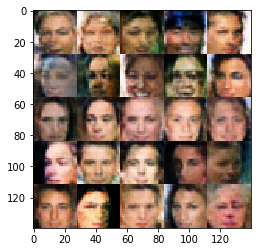

Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.2388
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.2820


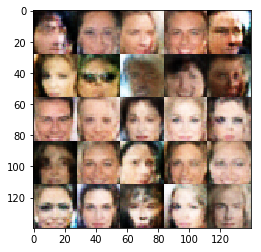

Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.4027
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 0.9937


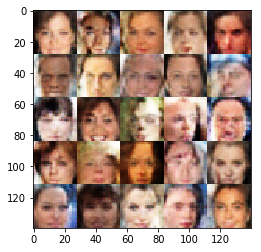

Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.1974
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 0.7342


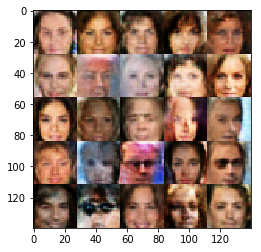

Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 2.0101
Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 0.5366


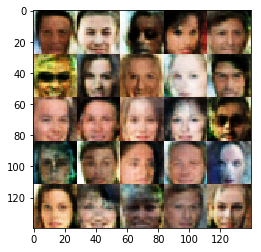

Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.3232
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.3557
Epoch 1/2... Discriminator Loss: 0.6500... Generator Loss: 1.7912
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.7870... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 0.6882... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 1.2191
Epoch 2/2... Discriminator Loss: 0.4391... Generator Loss: 2.0622
Epoch 2/2... Discriminator Loss: 1.7075... Generator Loss: 0.2802


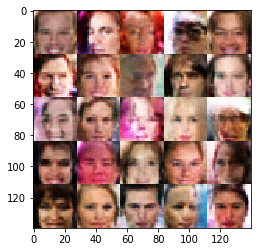

Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.4236
Epoch 2/2... Discriminator Loss: 0.4044... Generator Loss: 2.7251
Epoch 2/2... Discriminator Loss: 0.6200... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 0.4214... Generator Loss: 2.4528
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.3394
Epoch 2/2... Discriminator Loss: 0.4905... Generator Loss: 3.0004
Epoch 2/2... Discriminator Loss: 0.2682... Generator Loss: 2.2529


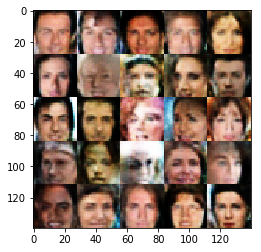

Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 1.5059
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 1.9004
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 1.3226
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.4215
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.7228... Generator Loss: 0.2665
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.6048
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.4415


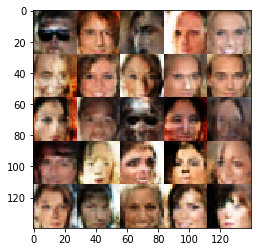

Epoch 2/2... Discriminator Loss: 0.7847... Generator Loss: 3.0500
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 2.7725
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 0.9978
Epoch 2/2... Discriminator Loss: 0.2954... Generator Loss: 2.2075
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 2.4535
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.3490... Generator Loss: 2.7651
Epoch 2/2... Discriminator Loss: 0.4709... Generator Loss: 1.4677


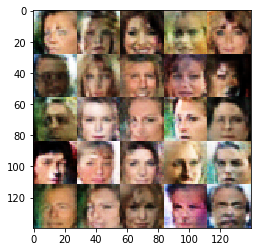

Epoch 2/2... Discriminator Loss: 0.5319... Generator Loss: 1.2311
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 0.4513... Generator Loss: 1.4806
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 0.2281... Generator Loss: 2.4641
Epoch 2/2... Discriminator Loss: 0.3174... Generator Loss: 4.0612
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.0510
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.3325
Epoch 2/2... Discriminator Loss: 1.5884... Generator Loss: 3.0105
Epoch 2/2... Discriminator Loss: 0.2759... Generator Loss: 3.0021


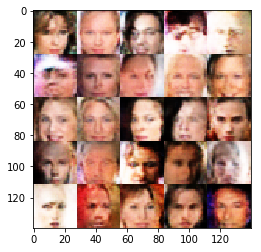

Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 4.3527
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 1.6723
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 3.9585
Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: 0.3581... Generator Loss: 2.5740
Epoch 2/2... Discriminator Loss: 0.1758... Generator Loss: 3.1111
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 5.6968
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 2.2778
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 1.4458


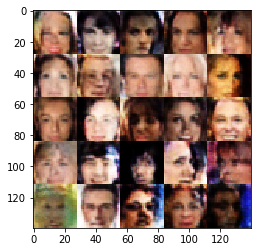

Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 4.0179
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.5609
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 0.1362... Generator Loss: 2.7304
Epoch 2/2... Discriminator Loss: 0.1383... Generator Loss: 2.7742
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.3108
Epoch 2/2... Discriminator Loss: 0.5228... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.5005


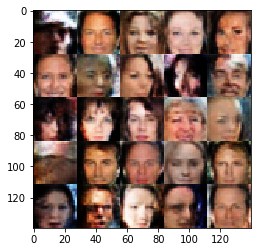

Epoch 2/2... Discriminator Loss: 0.3822... Generator Loss: 1.8455
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 1.9174... Generator Loss: 0.2003
Epoch 2/2... Discriminator Loss: 0.3211... Generator Loss: 2.1984
Epoch 2/2... Discriminator Loss: 0.4454... Generator Loss: 3.8468
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 2.3203
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 3.7582
Epoch 2/2... Discriminator Loss: 0.1508... Generator Loss: 4.0065
Epoch 2/2... Discriminator Loss: 0.1346... Generator Loss: 2.8510
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 0.9068


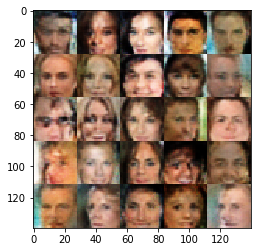

Epoch 2/2... Discriminator Loss: 0.1824... Generator Loss: 2.8788
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 0.2975... Generator Loss: 1.7935
Epoch 2/2... Discriminator Loss: 0.1474... Generator Loss: 3.1929
Epoch 2/2... Discriminator Loss: 0.2783... Generator Loss: 2.6664
Epoch 2/2... Discriminator Loss: 0.2389... Generator Loss: 5.1840
Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.1351... Generator Loss: 2.6913
Epoch 2/2... Discriminator Loss: 0.2568... Generator Loss: 2.1805
Epoch 2/2... Discriminator Loss: 0.1489... Generator Loss: 2.7477


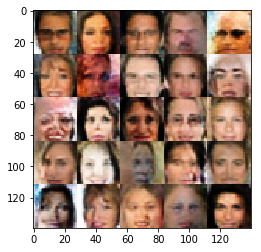

Epoch 2/2... Discriminator Loss: 0.1646... Generator Loss: 4.4799
Epoch 2/2... Discriminator Loss: 0.1246... Generator Loss: 3.1485
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 1.9100
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 0.6551... Generator Loss: 1.4853
Epoch 2/2... Discriminator Loss: 0.3191... Generator Loss: 2.7786
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.1789... Generator Loss: 3.0770


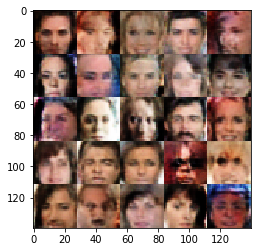

Epoch 2/2... Discriminator Loss: 0.3197... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 0.2397... Generator Loss: 4.6503
Epoch 2/2... Discriminator Loss: 0.1748... Generator Loss: 2.5995
Epoch 2/2... Discriminator Loss: 0.1963... Generator Loss: 2.1526
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.1648
Epoch 2/2... Discriminator Loss: 2.2203... Generator Loss: 3.2320
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.6560
Epoch 2/2... Discriminator Loss: 0.3023... Generator Loss: 3.1645
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 1.6502
Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 2.7101


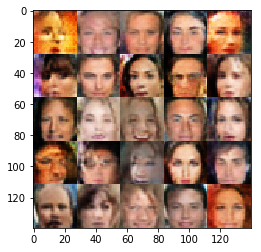

Epoch 2/2... Discriminator Loss: 0.3204... Generator Loss: 1.6027
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 2.8162
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 1.6352
Epoch 2/2... Discriminator Loss: 0.3294... Generator Loss: 2.7771
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 0.2956... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.1775... Generator Loss: 3.8954
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.7355
Epoch 2/2... Discriminator Loss: 0.2633... Generator Loss: 1.9319
Epoch 2/2... Discriminator Loss: 0.1037... Generator Loss: 3.8379


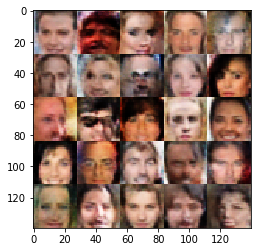

Epoch 2/2... Discriminator Loss: 0.1606... Generator Loss: 2.4277
Epoch 2/2... Discriminator Loss: 0.1583... Generator Loss: 3.2862
Epoch 2/2... Discriminator Loss: 0.3948... Generator Loss: 1.7778
Epoch 2/2... Discriminator Loss: 0.1805... Generator Loss: 2.3108
Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 3.5926
Epoch 2/2... Discriminator Loss: 0.2375... Generator Loss: 2.1114
Epoch 2/2... Discriminator Loss: 0.1003... Generator Loss: 3.5196
Epoch 2/2... Discriminator Loss: 2.4363... Generator Loss: 5.3419
Epoch 2/2... Discriminator Loss: 0.5627... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 0.4695... Generator Loss: 1.4213


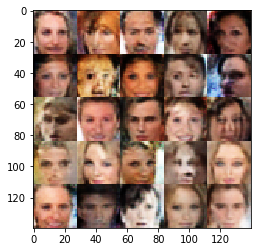

Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 1.7518
Epoch 2/2... Discriminator Loss: 0.2158... Generator Loss: 2.4912
Epoch 2/2... Discriminator Loss: 0.2402... Generator Loss: 2.6725
Epoch 2/2... Discriminator Loss: 0.2897... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 0.3267... Generator Loss: 1.6738
Epoch 2/2... Discriminator Loss: 0.0672... Generator Loss: 4.1643
Epoch 2/2... Discriminator Loss: 0.1191... Generator Loss: 3.0261
Epoch 2/2... Discriminator Loss: 0.2434... Generator Loss: 2.1614
Epoch 2/2... Discriminator Loss: 0.1241... Generator Loss: 3.2303
Epoch 2/2... Discriminator Loss: 5.7836... Generator Loss: 7.7778


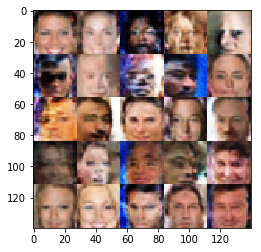

Epoch 2/2... Discriminator Loss: 0.3019... Generator Loss: 1.9241
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 1.7331
Epoch 2/2... Discriminator Loss: 2.1671... Generator Loss: 3.9157
Epoch 2/2... Discriminator Loss: 1.2108... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 0.2253... Generator Loss: 2.5208
Epoch 2/2... Discriminator Loss: 0.4331... Generator Loss: 1.2951
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 0.4974... Generator Loss: 1.3769
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.7407


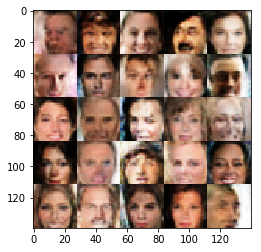

Epoch 2/2... Discriminator Loss: 0.1685... Generator Loss: 2.4652
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.5034
Epoch 2/2... Discriminator Loss: 0.3585... Generator Loss: 2.0703
Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 1.9296
Epoch 2/2... Discriminator Loss: 0.3525... Generator Loss: 2.7636
Epoch 2/2... Discriminator Loss: 0.2688... Generator Loss: 2.4641
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 0.1384... Generator Loss: 3.3378
Epoch 2/2... Discriminator Loss: 0.1721... Generator Loss: 2.4096


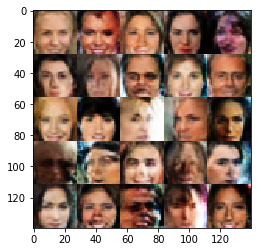

Epoch 2/2... Discriminator Loss: 0.1824... Generator Loss: 2.1990
Epoch 2/2... Discriminator Loss: 0.2082... Generator Loss: 2.2439
Epoch 2/2... Discriminator Loss: 0.1474... Generator Loss: 2.5648
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 2.8206
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 3.8648
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.3058
Epoch 2/2... Discriminator Loss: 0.2427... Generator Loss: 2.0270
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 3.2499
Epoch 2/2... Discriminator Loss: 0.3130... Generator Loss: 2.0855


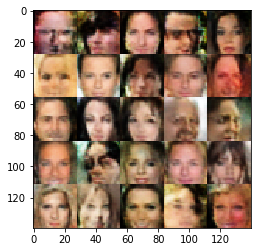

Epoch 2/2... Discriminator Loss: 0.3027... Generator Loss: 1.7840
Epoch 2/2... Discriminator Loss: 3.4282... Generator Loss: 0.0677
Epoch 2/2... Discriminator Loss: 1.6669... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 1.8663
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.2922... Generator Loss: 1.9400
Epoch 2/2... Discriminator Loss: 0.2767... Generator Loss: 2.2119
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.3305


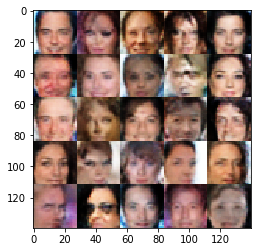

Epoch 2/2... Discriminator Loss: 0.4205... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 0.4796... Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.4353
Epoch 2/2... Discriminator Loss: 0.2020... Generator Loss: 3.6925
Epoch 2/2... Discriminator Loss: 0.1958... Generator Loss: 2.2706
Epoch 2/2... Discriminator Loss: 0.2573... Generator Loss: 2.1573
Epoch 2/2... Discriminator Loss: 0.2307... Generator Loss: 4.4541
Epoch 2/2... Discriminator Loss: 0.1630... Generator Loss: 2.7657
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 2.1080
Epoch 2/2... Discriminator Loss: 0.2023... Generator Loss: 2.4549


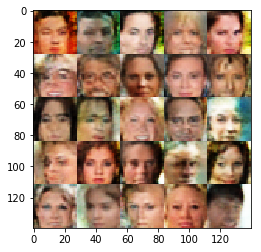

Epoch 2/2... Discriminator Loss: 0.2793... Generator Loss: 2.3853
Epoch 2/2... Discriminator Loss: 0.1286... Generator Loss: 2.8856
Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 1.6851
Epoch 2/2... Discriminator Loss: 0.5365... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 1.1968
Epoch 2/2... Discriminator Loss: 0.1885... Generator Loss: 2.3235
Epoch 2/2... Discriminator Loss: 0.1910... Generator Loss: 2.5198
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 1.5076


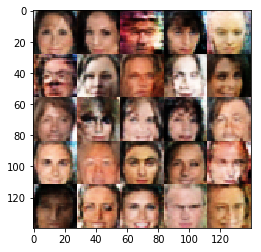

Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 3.8543
Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 0.2893... Generator Loss: 3.6301
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 0.2249... Generator Loss: 3.7423
Epoch 2/2... Discriminator Loss: 0.1631... Generator Loss: 2.6645
Epoch 2/2... Discriminator Loss: 1.7602... Generator Loss: 0.2907
Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 1.1623
Epoch 2/2... Discriminator Loss: 0.5559... Generator Loss: 1.2058


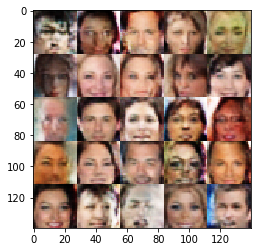

Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 0.2281... Generator Loss: 2.8057
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 1.5525
Epoch 2/2... Discriminator Loss: 0.2953... Generator Loss: 4.5246
Epoch 2/2... Discriminator Loss: 0.3606... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 0.3488... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 0.3432... Generator Loss: 2.9247
Epoch 2/2... Discriminator Loss: 0.3673... Generator Loss: 2.0996
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 0.1542... Generator Loss: 3.1509


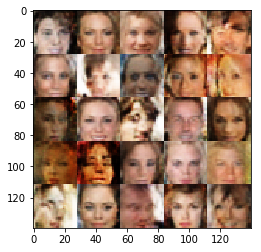

Epoch 2/2... Discriminator Loss: 0.3144... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 0.1085... Generator Loss: 3.8320
Epoch 2/2... Discriminator Loss: 0.4022... Generator Loss: 1.3854
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 0.3204... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.2394... Generator Loss: 2.4330
Epoch 2/2... Discriminator Loss: 0.3471... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 0.1684... Generator Loss: 2.3247
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.1804


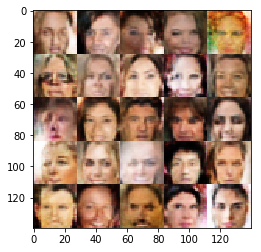

Epoch 2/2... Discriminator Loss: 0.1548... Generator Loss: 3.8922
Epoch 2/2... Discriminator Loss: 1.8498... Generator Loss: 0.2533
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 1.3934


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.